***
# <center> Multi-Armed Bandits
## <center> Epsilon-Greedy
***

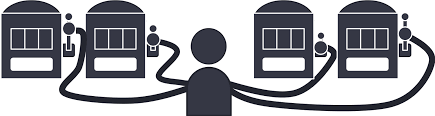

<b>Multi-Armed Bandit Problem</b>:

* Imagine you're at a casino, and in front of you are several slot machines(bandits). You know each machine offers a payout, but you have no idea how often they pay or how much. Your goal is to leave with as much money as possible. So, what do you do? Do you spend some time testing each machine to figure out which one is most likely to pay out? Or do you stick with the one that seems the best after a few initial trials? This is the exploration vs. exploitation trade-off.
$$$$
* The challenge is finding the right balance. Explore too much, and you waste time and resources on options that might not pay off. If you fully commit to one option and exploit too early, you might miss out on an even better option that you didn’t test enough.
$$$$
* There are various methods to solve the multi-armed bandit problem, each designed to balance exploration and exploitation in different ways. In this project I will be using Epsilon-Greedy with Decaying Epsilon.
$$$$
* This project was informed by *Experimentation for Engineers: From A/B Testing to Bayesian Optimization by David Sweet*.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## Simulated Bandits

In [36]:
def measure_click(ctr):
    return 1 if np.random.uniform(0,1) < ctr else 0

In [37]:
def measure_arm(i_arm):
    return measure_click(ctr=0.005+i_arm*0.002)

* measure_click(ctr): Simulates a click event. It returns 1 with probability roughly equal to ctr and 0 otherwise
$$$$
* measure_arm(i_arm): Simulates a click for a specific arm by calculating its ctr (0.005 + i_arm * 0.002) and using measure_click to determine if a click occurred.

## Epsilon Greedy with Decaying Epsilon

* With probability 1-epsilon this algorithm uses whichever version has a higher ctr so far. Otherwise, with probability epsilon, it acts like an A/B test and just chooses between the arms with equal probability. If you were to pass epsilon=1, it would behave the same as an A/B test throughout - assuming the epsilon term were constant.

* However in this implementation, epsilon will be decaying. At each iteration it will be set to:

$$Epsilon = K \cdot c \cdot \frac{\left(\frac{BM_{max}}{PS}\right)^2}{n}$$
where:

$K$ is the number of arms

$BM_{max}$ is largest plausible business metric

$PS$ is practical significance

<b>c</b> controls the amount of time epsilon spends above 1, in pure exploration

* In this implementation:

<b>K</b> = 4

$BM_{max} = 0.01$:  the maximum meaningful CTR for any arm is 1%

<b>prac_sig</b> = 0.001: a CTR difference of 0.001 (0.1%) is the smallest meaningful difference

<b>epsilon_stop</b> = 0.01: the algorithm will explore until epsilon decays to 0.01 (1%), meaning there’s a 1% chance of exploring a non-optimal arm in later iterations.

In [93]:
def epsilon_greedy_decay(c, track_evolution=False):
    bm_max = 0.01
    prac_sig = 0.001
    k = 4

    epsilon_0 = k * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01

    sum_arm = [0.0] * k
    num_arm = [0.0] * k
    ctr_vs_n = []
    arms_selected = []

    epsilon_values = []  
    ctr_estimates = [[] for _ in range(k)]  

    n = 0
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        if track_evolution:
            epsilon_values.append(epsilon)  

        if epsilon < epsilon_stop:
            break

        if np.random.uniform(0, 1) < 1 - epsilon:
            i_selected = np.argmax([sum_arm[i] / num_arm[i] if num_arm[i] > 0 else 0 for i in range(k)])
        else:
            i_selected = np.random.randint(k)

        arms_selected.append(i_selected)
        clicked = measure_arm(i_selected)
        sum_arm[i_selected] += clicked
        num_arm[i_selected] += 1

        if track_evolution:
            for i in range(k):
                if num_arm[i] > 0:
                    ctr_estimates[i].append(sum_arm[i] / num_arm[i])
                else:
                    ctr_estimates[i].append(0)

        n += 1

    if track_evolution:
        return ctr_vs_n, arms_selected, epsilon_values, ctr_estimates
    else:
        return ctr_vs_n, arms_selected

## Tune C

* Regret is calculated like this:
$$\sum_{i=1}^{t}\mu^* - \sum_{i=1}^{t}\mu_{a_{i}}$$

Where:

$\mu^*$ is the expected reward of the optimal arm

$\mu_{a_{i}}$ is the expected reward of the arm selected at iteration i

In [69]:
def tune_c(c_values, num_runs=10, k=4):
    bm_max = 0.01
    prac_sig = 0.001
    true_ctr = [0.005 + i * 0.002 for i in range(k)]
    mu_star = max(true_ctr)

    results = []
    for c in c_values:
        cumulative_rewards = []
        cumulative_regrets = []
        iteration_counts = []  

        for _ in range(num_runs):
            ctr_vs_n, arms_selected = epsilon_greedy_decay(c)
            cumulative_rewards.append(sum(ctr_vs_n))
            cumulative_regrets.append(sum(mu_star - true_ctr[arm] for arm in arms_selected))
            iteration_counts.append(len(arms_selected)) 

        avg_reward = np.mean(cumulative_rewards)
        avg_regret = np.mean(cumulative_regrets)
        avg_iterations = np.mean(iteration_counts) 
        results.append((c, avg_reward, avg_regret, avg_iterations))

    c_vals, avg_rewards, avg_regrets, avg_iterations = zip(*results)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(c_vals, avg_rewards, label="Avg Cumulative Reward", marker='o')
    plt.xlabel("c")
    plt.ylabel("Average Cumulative Reward")
    plt.title("Average Cumulative Reward vs. c")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(c_vals, avg_regrets, label="Avg Regret", marker='o', color='red')
    plt.xlabel("c")
    plt.ylabel("Average Regret")
    plt.title("Average Regret vs. c")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(c_vals, avg_iterations, label="Avg Iterations", marker='o', color='green')
    plt.xlabel("c")
    plt.ylabel("Average Iterations")
    plt.title("Average Iterations vs. c")
    plt.grid()

    plt.tight_layout()
    plt.show()

    return results

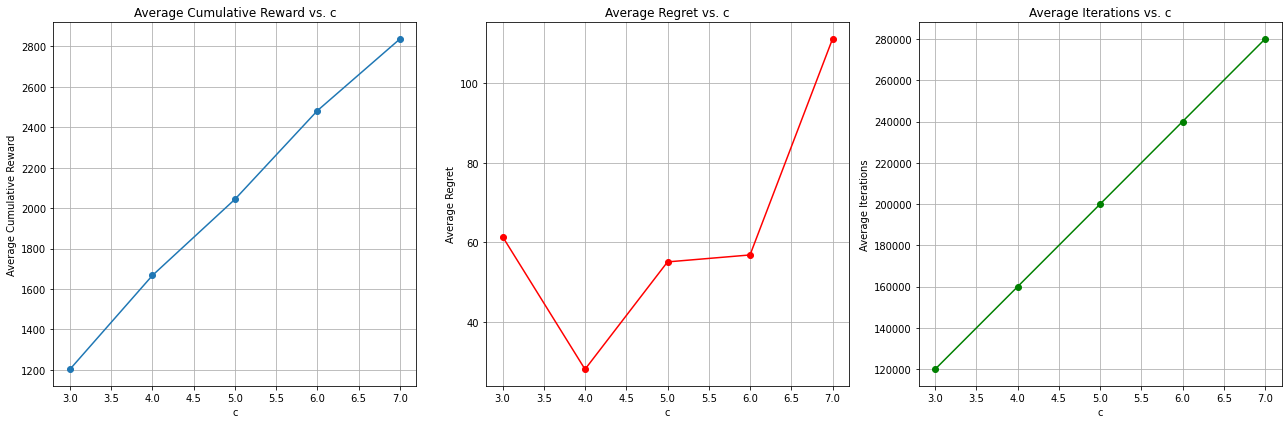

[(3, 1202.9845086968783, 61.46540000005668, 120000.0),
 (4, 1667.3410127970892, 28.16960000000024, 160000.0),
 (5, 2044.0520695888063, 55.11020000000885, 200000.0),
 (6, 2482.6100701102705, 56.854800000010925, 240000.0),
 (7, 2837.168446830444, 111.05640000000683, 280000.0)]

In [70]:
np.random.seed(1)
tune_c([3,4,5,6,7])

* c = 5 appears to be the best choice because it achieves a strong balance between high cumulative reward, low regret and a reasonable number of iterations.

## Analyzing Model at c=5

In [82]:
def analyze_single_run(c=5, k=4):
    ctr_vs_n, arms_selected = epsilon_greedy_decay(c)

    true_ctr = [0.005 + i * 0.002 for i in range(k)]
    mu_star = max(true_ctr)
    total_clicks = sum(ctr_vs_n)
    total_regret = sum(mu_star - true_ctr[arm] for arm in arms_selected)
    
    total_selections = len(arms_selected)
    arm_selection_proportions = [arms_selected.count(i) / total_selections for i in range(k)]

    num_iterations = total_selections

    print(f"Total Clicks (Cumulative Reward): {np.ceil(total_clicks)}")
    print(f"Total Regret: {np.round(total_regret,2)}")
    print(f"Arm Selection Distribution (Proportions): {np.round(arm_selection_proportions,2)}")
    print(f"Number of Iterations: {num_iterations}")

In [83]:
np.random.seed(1)
analyze_single_run()

Total Clicks (Cumulative Reward): 2137.0
Total Regret: 34.58
Arm Selection Distribution (Proportions): [0.01 0.01 0.02 0.95]
Number of Iterations: 200000


* The epsilon-greedy algorithm with c = 5 performed 200,000 iterations, achieving a cumulative reward of 2137  and a relatively low regret of 34.58. The arm selection proportions show that the algorithm heavily favored Arm 3 (95%), while Arms 0, 1, and 2 were selected minimally, suggesting that Arm 3 was identified as the optimal choice early in the process.

## Looking at the evolution

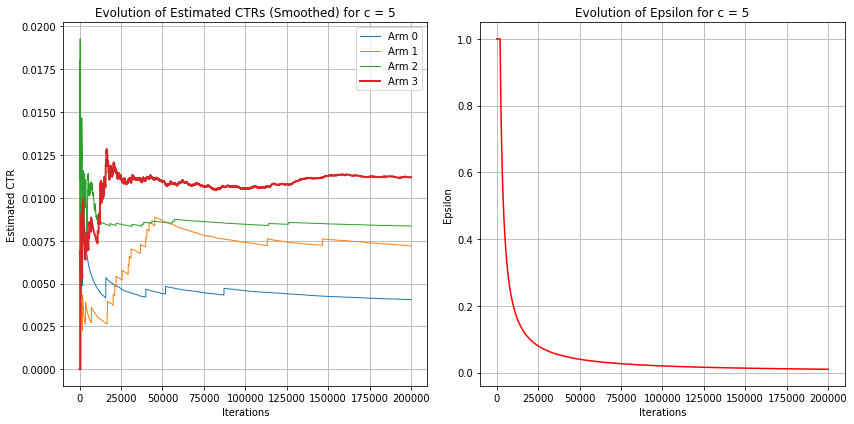

In [95]:
def plot_evolution(c=5, k=4, window=50):
    _, _, epsilon_values, ctr_estimates = epsilon_greedy_decay(c, track_evolution=True)

    smoothed_ctrs = [np.convolve(ctr, np.ones(window) / window, mode="valid") for ctr in ctr_estimates]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for i in range(k):
        plt.plot(
            smoothed_ctrs[i],
            label=f"Arm {i}",
            linewidth=2 if i == np.argmax([np.mean(ct) for ct in ctr_estimates]) else 1
        )
    plt.xlabel("Iterations")
    plt.ylabel("Estimated CTR")
    plt.title(f"Evolution of Estimated CTRs (Smoothed) for c = {c}")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_values, label="Epsilon", color='red')
    plt.xlabel("Iterations")
    plt.ylabel("Epsilon")
    plt.title(f"Evolution of Epsilon for c = {c}")
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evolution()

* The algorithm successfully identifies the optimal arm (Arm 3) and exploits it consistently, as evidenced by the stable CTR estimate and the convergence of epsilon toward 0.01.

## Conclusion

In this project Epsilon Greedy with Decaying Epsilon was used but there are other methods one could use. These include Epsilon-Greedy(with constant epsilon), Upper Confidence Bound, Thompson Sampling and several more. Applications of multi-armed bandit problems include:

<b>Online Advertising</b>: Selecting which ads to show to maximize click-through rates.

<b>Clinical Trials</b>: Allocating patients to different treatments to find the most effective one.

<b>A/B Testing</b>: Dynamically testing multiple variations of a product or webpage to optimize performance.

<b>Recommender Systems</b>: Suggesting content or products to users based on their preferences.